In [1]:
#A collection of written texts
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [2]:
# We need to remove articles,be forms,notations etc
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [3]:
corpus = remove_stop_words(corpus)
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [4]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [5]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [6]:
import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [9]:
df.head()

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king


In [10]:
word2int

{'strong': 0,
 'boy': 1,
 'king': 2,
 'wise': 3,
 'young': 4,
 'queen': 5,
 'girl': 6,
 'princess': 7,
 'man': 8,
 'prince': 9,
 'woman': 10,
 'pretty': 11}

In [11]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

C:\Users\Ayra\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  2.945526
iteration 3000 loss is :  1.8824729
iteration 6000 loss is :  1.8063308
iteration 9000 loss is :  1.7834811
iteration 12000 loss is :  1.7691398
iteration 15000 loss is :  1.7595872
iteration 18000 loss is :  1.7524801


In [13]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)

[[-0.7823299   6.933809  ]
 [-0.14195704  3.707436  ]
 [-0.38274062  0.9839977 ]
 [ 5.730986    1.9395466 ]
 [ 0.14974463  0.2899704 ]
 [ 1.1099433   0.21555293]
 [ 3.2461715   1.5206456 ]
 [ 3.2315207   0.61938506]
 [-0.66460335  0.95844895]
 [-0.85871446  3.053172  ]
 [ 0.7479442  -0.2745955 ]
 [ 4.528424    2.70934   ]]


In [14]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,strong,-0.782330,6.933809
1,boy,-0.141957,3.707436
2,king,-0.382741,0.983998
3,wise,5.730986,1.939547
4,young,0.149745,0.289970
5,queen,1.109943,0.215553
6,girl,3.246171,1.520646
7,princess,3.231521,0.619385
8,man,-0.664603,0.958449
9,prince,-0.858714,3.053172


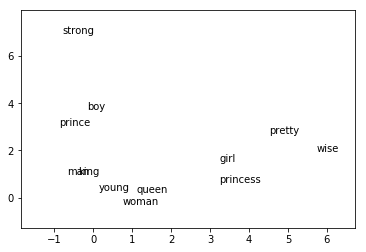

In [16]:
import matplotlib.pyplot as plt
% matplotlib inline
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()